In [1]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
import scipy.io as spio
import os
from os.path import dirname, join as pjoin
from numpy import array
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from collections import Counter
import seaborn as sns
import glob
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/"My Drive"/"NDT Phase II"/

/content/gdrive/My Drive/NDT Phase II


In [0]:
mat_path = pjoin('Dataset','data.mat')
mat = spio.loadmat(mat_path)

In [5]:
cell_data = mat['data']
cell_data.shape

(256, 320, 250)

In [6]:
dt = np.transpose(cell_data)
dt.shape

(250, 320, 256)

In [7]:
dt[0].shape

(320, 256)

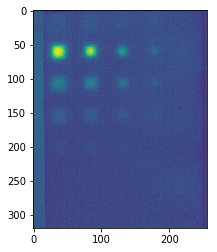

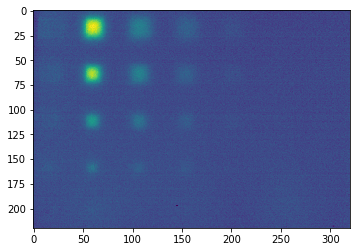

In [8]:
img1 = dt[100]
plt.imshow(img1)
plt.show()
img2 = np.transpose(img1)
plt.imshow(img2[20:240])
plt.show()

In [0]:
def remove_edges(data):
    data_tr2 = np.zeros((250,256,320))
    data_tr3 = np.zeros((250,220,320))
    for i in range(0,250):
        data_tr = np.transpose(data)
        data_tr2[i] = np.transpose(data_tr[i])
        data_tr3[i] = data_tr2[i][20:240]
    return data_tr3    

In [10]:
d = remove_edges(cell_data)
d.shape

(250, 220, 320)

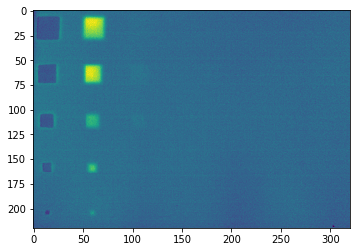

In [11]:
plt.imshow(d[10])

In [0]:
#non defected strip between 1st and 2nd coloumn 
def non_defected_region_points(data):
    nd_points = []
    im = data[10]
    for i in range(0,220):
        for j in range(0,320):
            if(im[i][j]<1.2 and j<45 and j>30):
                nd_points.append((i,j))
    print(len(nd_points))
    return nd_points

In [13]:
nd_points = non_defected_region_points(d)

3080


In [0]:
#second coloumn defected points
def defected_region_points(data):
    d_points = []
    im = data[10]
    for i in range(0,220):
        for j in range(0,320):
            if(im[i][j]>1.34):
                d_points.append((i,j))
    print(len(d_points))
    return d_points

In [15]:
d_points = defected_region_points(d)

1060


In [0]:
def get_defected_data(d,nd_points,d_points):
    data = []
    target = []
    for (i,j) in d_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        data.append(d1)      
        target.append([0])
    for (i,j) in nd_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        data.append(d1)
        target.append([1])
    return data,target

In [17]:
data_train,target_train = get_defected_data(d,nd_points,d_points)
np.array(data_train).shape,np.array(target_train).shape

((4140, 200), (4140, 1))

In [0]:
class Args:
    def __init__(self):
        self.cuda = True
        self.no_cuda = False
        self.seed = 1
        self.epochs = 30
        self.lr = 0.0001
args = Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

In [0]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        self.rnn = nn.LSTM(input_size = 200, hidden_size = 256, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(256,2)
    def forward(self,x):
        r_in = x.view(1, 1, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        return F.log_softmax(r_out2, dim=1)

In [0]:
def get_data(data_train,target_train):
    data_array = array(data_train)
    data = torch.from_numpy(data_array);
    target = torch.from_numpy(array(target_train));
    return data,target

In [0]:
def train(epoch):
    e = []
    l = []
    model.train()
    c = []
    for i in range(1,len(data_train)+1):
        c.append(i)
    random.shuffle(c)
    for i in range(1,len(data_train)-1):
        data,target = get_data(data_train[c[i]-1],target_train[c[i]-1])
        data = np.expand_dims(data, axis=1)
        data = torch.FloatTensor(data)
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = F.nll_loss(output, target)
        l.append(loss.item()) 
        loss.backward()
        optimizer.step()
    return 

In [0]:
#plt.switch_backend('agg')
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
model = LSTM()
if args.cuda: 
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9,0.999))

In [0]:
for epoch in range(1, args.epochs + 1):
    train(epoch)

KeyboardInterrupt: ignored

In [0]:
mat_path2 = pjoin('Dataset','Square Sample 2.mat')
mat2 = spio.loadmat(mat_path2)

In [25]:
mat2.keys()
cell_data2 = mat2['I']
cell_data2.shape

(256, 320, 200)

In [26]:
dt2 = np.transpose(cell_data2)
dt2.shape

(200, 320, 256)

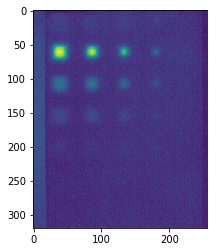

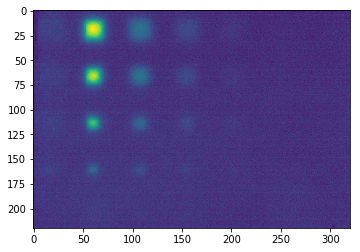

In [27]:
img3 = dt2[100]
plt.imshow(img3)
plt.show()
img4 = np.transpose(img3)
plt.imshow(img4[20:240])
plt.show()

In [0]:
#non defected strip between 1st and 2nd coloumn 
def non_defected_region_points2(data):
    nd_points = []
    im = data[10]
    for i in range(0,320):
        for j in range(0,256):
            if(im[i][j]<1.2 and j<45 and j>30):
                nd_points.append((i,j))
    print(len(nd_points))
    return nd_points

In [29]:
nd_points2 = non_defected_region_points2(dt2)

4113


In [0]:
#second coloumn defected points
def defected_region_points2(data):
    d_points = []
    im = data[10]
    for i in range(0,320):
        for j in range(0,256):
            if(im[i][j]>1.34):
                d_points.append((i,j))
#                 im[i,j] = 0
#     plt.imshow(im)
    print(len(d_points))
    return d_points

In [31]:
d_points2 = defected_region_points2(dt2)

1221


In [0]:
def get_defected_data2(d,nd_points,d_points):
    data = []
    target = []
    data2 = []
    target2 = []
    c = 0
    for (i,j) in d_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        if(c<500):
          data.append(d1)      
          target.append([0])
          c+=1
        else:
          data2.append(d1)
          target2.append([0])
          
    for (i,j) in nd_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        if(c<1000):
          data.append(d1)
          target.append([1])
          c+=1
        else:
          data2.append(d1)
          target2.append([1])
    return data,target,data2,target2

In [0]:
def get_defected_data3(d,nd_points,d_points):
    data = []
    target = []
    data2 = []
    target2 = []
    c = 0
    for (i,j) in d_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        data2.append(d1)
        target2.append([0])

    for (i,j) in nd_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        data2.append(d1)
        target2.append([1])
    return data2,target2

In [34]:
data_test,target_test = get_defected_data3(dt2,nd_points2,d_points2)
np.array(data_test).shape,np.array(target_test).shape

((5334, 200), (5334, 1))

In [0]:
# data_val,target_val,data_test,target_test = get_defected_data2(dt2,nd_points2,d_points2)
# np.array(data_test).shape,np.array(target_test).shape,np.array(data_val).shape,np.array(target_val).shape

In [0]:
def val(epoch):
    e = []
    l = []
    p = []
    t = []
    test_loss = 0
    model.eval()
    c = []
    for i in range(1,len(data_val)+1):
        c.append(i)
    random.shuffle(c)
    for i in range(1,len(data_val)-1):
        data,target = get_data(data_val[c[i]-1],target_val[c[i]-1])
        p1,q = d_points2[c[i]-1]
        data = np.expand_dims(data, axis=1)
        data = torch.FloatTensor(data)
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        test_loss += F.nll_loss(output, target).sum().item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if(pred.item()):
          im = dt2[10]
          im[p1][q] = 0
        p.append(pred.item())
        t.append(target.item())
    f = f1_score(t,p, average='macro')
    c = confusion_matrix(t,p)
    a = accuracy_score(t,p)
    print("val accuracy :",a)
    return im

In [37]:
print(len(d_points2),len(nd_points2))
total_points = [*d_points2,*nd_points2]
len(total_points)

1221 4113


5334

In [0]:
def test(epoch):
    e = []
    l = []
    p = []
    t = []
    im = dt2[10]
    test_loss = 0
    model.eval()
    c = []
    for i in range(1,len(data_test)+1):
        c.append(i)
    random.shuffle(c)
    for i in range(1,len(data_test)-1):
        data,target = get_data(data_test[c[i]-1],target_test[c[i]-1])
        data = np.expand_dims(data, axis=1)
        data = torch.FloatTensor(data)
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        test_loss += F.nll_loss(output, target).sum().item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if(not pred.item()):    
            p1,q = total_points[c[i]-1]
            im[p1][q] = 0
        p.append(pred.item())
        t.append(target.item())
    f = f1_score(t,p, average='macro')
    c = confusion_matrix(t,p)
    a = accuracy_score(t,p)
    plt.imshow(im)
    plt.show()
    print('test accuracy :',a)

Epoch :  1


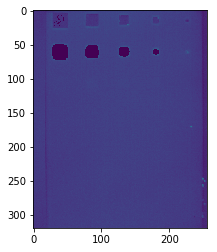

test accuracy : 0.9679294823705926
Epoch :  2


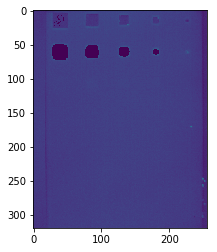

test accuracy : 0.9686796699174793
Epoch :  3


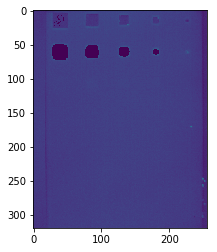

test accuracy : 0.9714928732183046
Epoch :  4


KeyboardInterrupt: ignored

In [44]:
for epoch in range(1, args.epochs + 1):
    print('Epoch : ',epoch)
    train(epoch)
#     i = val(epoch)
    test(epoch)